In [1]:
import wrds
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#importing libraries and setting graphical parameters
import matplotlib
matplotlib.rcParams["figure.dpi"] = 110
#creating the connection 
db = wrds.Connection(wrds_username="djolitto")


Loading library list...
Done


In [3]:
#retrieving data 
#1.
mark = db.raw_sql("select date,vwretd from crsp.dsi where date >= '2011-01-01' and date <= '2021-12-31'")
tbill = db.raw_sql("select caldt, tdyld from crsp.tfz_dly_rf2 where kytreasnox = 2000061 and caldt >= '2011-01-01' and caldt <= '2021-12-31'")
netflix = db.raw_sql("select date, permno, ret from crsp.dsf where permno in (89393) and date>='2011-01-01' and date<='2021-12-31'")
tbill = tbill.rename(columns={"caldt":"date"})   #calling date the column with dates 


In [4]:

#note that they have different length so we need to select values only for date where we have both 
#we notice that the data have different length so we need to merge data based on the value of date 
data = pd.merge(netflix, tbill, on ="date")
data = pd.merge(data, mark, on="date")
data = data.set_index(data.date)
data = data.drop(columns=["date","permno"])
data = data.rename(columns={"ret":"netflix", "tdyld":"tbill", "vwretd":"market"})
#visualizing the dataframe 
print(data.head())

             netflix     tbill    market
date                                    
2011-01-03  0.015424  0.000003  0.011216
2011-01-04  0.016591  0.000003 -0.003896
2011-01-05 -0.009042  0.000003  0.005386
2011-01-06 -0.009681  0.000004 -0.002516
2011-01-07  0.007360  0.000004 -0.001951



Average beta:  1.284661867598342 


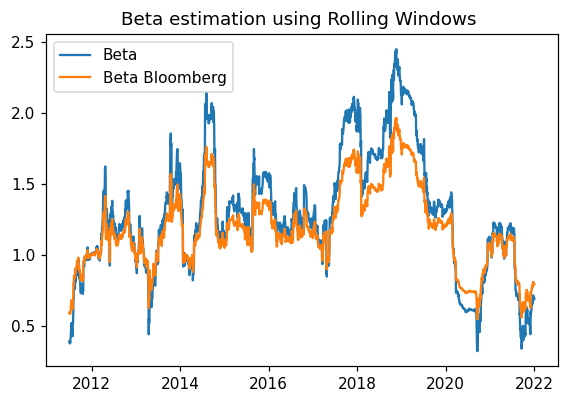

In [6]:
#2.
#create a dataframe containing the stock premium and the market premium 
reg = pd.DataFrame({'stock_premium': (data.netflix -data.tbill).values , 'market_premium': (data.market - data.tbill).values, })
reg = reg.set_index(pd.DatetimeIndex(data.index))  #setting date as index of the dataframe 

#calculate the covariance matrix using a rolling windows of 126 
#we have used 126 for the fact that is 0.5*trading days = 252
cov_mat = reg.rolling(126).cov().dropna()   

#calculate the variance matrix in rolling windows
variance = reg.market_premium.rolling(126).var().dropna() #calculate the variance in rolling windows 

#we extract from all the matrix the covariance between the two risk premium
covariance = cov_mat.unstack()["stock_premium"]["market_premium"] 

#calculating the beta 
beta = covariance/variance 

#average beta
avg_beta = beta.mean()
print(f'\nAverage beta:  {avg_beta} ')

#bloomberg adjusted estimate
beta_adj = beta*(2/3) + 1/3

#plotting
plt.plot(beta, label = "Beta")
plt.plot(beta_adj, label="Beta Bloomberg")
plt.legend()
plt.title("Beta estimation using Rolling Windows ")
plt.show()




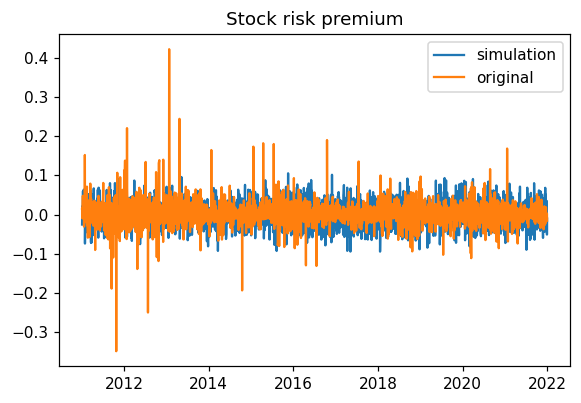

In [7]:
#3.
#we need to the simulate the market return and then we subtract from it the mean of the risk free asset 
epsilon_market = np.random.normal(0, data.market.std(), len(reg))  #simulating errors of market 
simulated_market_premium = (data.market.mean() + epsilon_market) - data.tbill.mean()  #simulating market risk premium
#to get the risk premium we subtract from simulated market return the mean of the tbill return 

#here we can use the standard deviation of the stock premium to get a simulation of stock risk premium
#we need to simulated white noise with variance equal to the idiosyncratic variance 
#then we do the same step as before to get the simulated risk premium 
var_to_use = reg.stock_premium.var() - avg_beta**2 * reg.market_premium.var()
epsilon = np.random.normal(0,var_to_use**(0.5),len(reg))  #errors to use in the simulation 
simulated_data =  avg_beta*simulated_market_premium + epsilon   #in this case we are not interested in the intercept so we ignore it 
simulated_data = pd.Series(simulated_data, index = pd.DatetimeIndex(data.index))


#visualize simulated and original data 
plt.plot(simulated_data, label = "simulation")
plt.plot(reg.stock_premium, label ="original")
plt.title("Stock risk premium")
plt.legend()
plt.show()



Average beta:  1.2674730258535505 



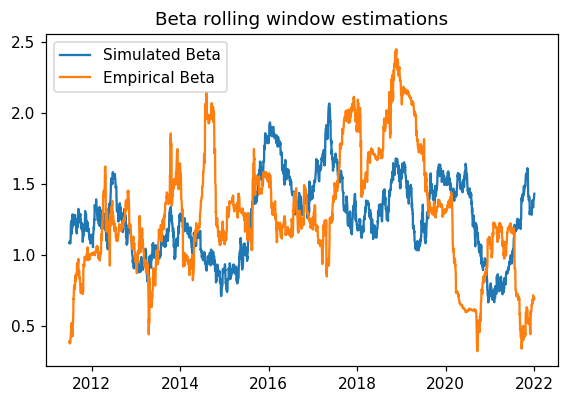

In [10]:
#note that here we used the same step as before changing the name to the variables
#now we can two to estimate the beta as before 
reg2 = pd.DataFrame({'stock_premium': simulated_data , 'market_premium': simulated_market_premium, })
reg2 = reg2.set_index(pd.DatetimeIndex(data.index))


cov_mat = reg2.rolling(126).cov().dropna()    #calculate the covariance matrix in rolling windows
variance = reg2.market_premium.rolling(126).var().dropna()    #calculate the variance in rolling windows 
#we extract from all the matrix the covariance between the two risk premium
covariance = cov_mat.unstack()["stock_premium"]["market_premium"] 

#calculating the beta 
beta_simulation = covariance/variance 

#average beta
avg_beta_simulation = beta_simulation.mean()
print(f'\nAverage beta:  {avg_beta_simulation} \n')

#plotting
plt.plot(beta_simulation, label = "Simulated Beta")
plt.plot(beta, label = "Empirical Beta")
plt.title("Beta rolling window estimations")
plt.legend()
plt.show()



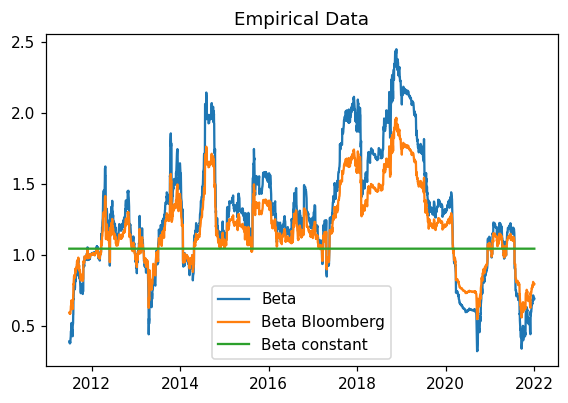

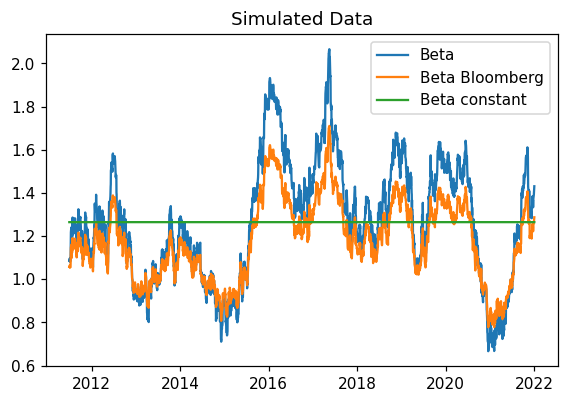

In [13]:
#4. 
#now we estimate the beta without using rolling windows
#actual constant beta 
covariance = reg.cov()["stock_premium"]["market_premium"]
variance = reg.market_premium.var()
beta_constant = covariance/variance
beta_constant = pd.Series([beta_constant for i in range(len(beta))], index=beta.index)

#plotting
plt.plot(beta, label = "Beta")
plt.plot(beta_adj, label="Beta Bloomberg")
plt.plot(beta_constant, label ="Beta constant")
plt.title("Empirical Data")
plt.legend()
plt.show()


#we can do the same with simulated beta
#bloomber beta adjusted 
beta_adj_simulation = beta_simulation*2/3 + 1/3
covariance = reg2.cov()["stock_premium"]["market_premium"]
variance = reg2.market_premium.var()
beta_constant_simulation = covariance/variance
beta_constant_simulation = pd.Series([beta_constant_simulation for i in range(len(beta))], index=beta.index)

#plotting
plt.plot(beta_simulation, label = "Beta")
plt.plot(beta_adj_simulation, label="Beta Bloomberg")
plt.plot(beta_constant_simulation, label ="Beta constant")
plt.title("Simulated Data")
plt.legend()
plt.show()


